In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import scipy.stats as sps
import sklearn
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
import time

In [2]:
#Parameters
S0 = 100
r = 0.043
sigma = 0.4
rho = 0.75 # Correlation of brownian motions
T = 1
range_K = np.arange(80, 121)

nb_sample = 20000 

# Default value ok K
fixed_K = 100
ind_K = list(range_K).index(fixed_K)

### Payoff and call price

In [3]:
def f(Z, K):
    ## Function computing the payoff
    S = S0*np.exp(sigma*np.sqrt(T)*Z - 0.5*T*sigma**2 + r*T)
    return np.maximum(0, np.mean(S,axis=1) - K)

def Call(K):
    #Calculates the European call option for a continuous time
    
    k = K*np.exp(-r*T)
    v = T*sigma**2
    d1 = ( np.log(S0/k)/np.sqrt(v) ) + np.sqrt(v)/2     #d+
    d2 = ( np.log(S0/k)/np.sqrt(v) ) - np.sqrt(v)/2     #d-
    
    return S0*sps.norm.cdf(d1) - k*sps.norm.cdf(d2)

### Model training (weigths, biases and analytical expectation)

In [4]:
def NN_model(Z_train, K, N, n, Cov):
    # defining our model
    # Z_train is a training vector
    # K is a fixed strike
    model = keras.Sequential()
    model.add( layers.Dense(units = 2, input_dim = N, use_bias=False, activation='linear') )
    model.add( layers.Dense(units = n, activation = 'relu' ))
    model.add(layers.Dense(units=n//10, activation='relu'))
    model.add( layers.Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the model
    Y_train = f(Z_train, K)
    model.fit(Z_train, Y_train)

    # Getting the weights:
    W1 = model.layers[0].get_weights()[0]
    W2, b2 = model.layers[1].get_weights()
    W3, b3 = model.layers[2].get_weights()
    W4, b4 = model.layers[3].get_weights()
    
    
    def h_tild(z_tild, W2, b2, W3, b3, W4, b4) :
        h_t = (np.maximum(((np.maximum(z_tild @ W2 + b2 , 0)) @ W3 + b3), 0) @ W4 + b4).flatten()
        return h_t
    
    # Calculation the expectation using numerical integration
    m = 600
    a, b = -20., 20.
    z = np.linspace(a,b,m)
    area = ((b-a)/m)**2
    
    z1,z2 = np.meshgrid(z,z)
    z = np.dstack((z1,z2)).reshape(-1,2)
    
    rv = sps.multivariate_normal([0.0,0.0], W1.T@Cov@W1)
    f_z = rv.pdf(z)
    h_t = h_tild(z, W2, b2, W3, b3, W4, b4)
    
    esp = np.sum(h_t*f_z) * area
    
    return W1, W2, b2, W3, b3, W4, b4, esp

### Computing the contole variate function

In [5]:
def NN_h(Z, W1, W2, b2, W3, b3, W4, b4):
    a1_Z =  Z @ W1
    return (np.maximum(((np.maximum(a1_Z @ W2 + b2 , 0)) @ W3 + b3), 0) @ W4 + b4).flatten()

def NN_f_ctrl(Z, K, W1, W2, b2, W3, b3, W4, b4, esp):
    return f(Z, K) - NN_h(Z, W1, W2, b2, W3, b3, W4, b4) + esp

### DIMENSION 10

In [6]:
N = 10     # dimension
n = 500   # number of neuronnes of the second hidden layer

# Sampling correlated bownian motions
Cov = np.eye(N)
Cov[Cov != 1] = rho
Z = np.random.multivariate_normal(np.zeros(N), Cov, nb_sample)

### Naive Monte Carlo Method VS Controle variate

In [7]:
# Option price with the naive Monte Carlo Method
ti_MC = time.time()

payoffs_MC = f(Z, fixed_K)
prices_MC = np.mean(payoffs_MC)*np.exp(-r*T)

tf_MC = time.time()

std_MC = np.std(payoffs_MC)*np.exp(-r*T)
IC_MC = prices_MC + 1.96 / np.sqrt(nb_sample) * np.array([-std_MC,std_MC])

In [8]:
# Option Price with Controle Variate Method
ti_train = time.time()
W1, W2, b2, W3, b3, W4, b4, esp = NN_model(Z, fixed_K, N, n, Cov)
tf_train = time.time()

625/625 [==============================] - 3s 3ms/step - loss: 95.8088


In [9]:
ti_compute = time.time()

payoffs_ctrl = NN_f_ctrl(Z, fixed_K, W1, W2, b2, W3, b3, W4, b4, esp)
prices_ctrl = np.mean(payoffs_ctrl)*np.exp(-r*T)

tf_compute = time.time()

std_ctrl = np.std(payoffs_ctrl)*np.exp(-r*T)
IC_ctrl = prices_ctrl + 1.96 / np.sqrt(nb_sample) * np.array([-std_ctrl,std_ctrl])

In [10]:
# Connfidence intervalls, Ratio of variance, cost and speed up
std_ctrl = np.std(payoffs_ctrl)*np.exp(-r*T)
IC_ctrl = prices_ctrl + 1.96 / np.sqrt(nb_sample) * np.array([-std_ctrl,std_ctrl])
var_ratio = (std_MC/std_ctrl)**2
cost = ((tf_train - ti_train) + (tf_compute - ti_compute))/(tf_MC - ti_MC)
speed_up = var_ratio/cost

In [11]:
print("Comparison between the Naive Monte Carlo Method and the Controle variate one")
print("==============================================================================\n\n")
print(f"Naive Monte Carlo price = {prices_MC}, IC = {IC_MC}\n")
print(f"Controle variate price = {prices_ctrl}, IC = {IC_ctrl}\n")
print(f"var_ratio = {var_ratio}\n")
print(f"Cost = {cost}\n")
print(f"Speed up = {speed_up}\n")

Comparison between the Naive Monte Carlo Method and the Controle variate one


Naive Monte Carlo price = 15.749124707857357, IC = [15.38556711 16.11268231]

Controle variate price = 15.780774985299317, IC = [15.73759639 15.82395358]

var_ratio = 70.8939817507581

Cost = 477.9400799724724

Speed up = 0.1483323636612383



#### Naive Monte Carlo method

In [12]:
payoffs_MC = np.zeros( (len(range_K), nb_sample) )

for i,K in enumerate(range_K):
    payoffs_MC[i,:] = f(Z, K)[:]
    
prices_MC = np.mean(payoffs_MC, axis =1)*np.exp(-r*T)
std_MC = np.std(payoffs_MC , axis = 1)*np.exp(-r*T)
IC_MC = prices_MC + 1.96 / np.sqrt(payoffs_MC.shape[1]) * np.array([-std_MC,std_MC])

#### Calculating the price option with NN controle variate in dim=10

In [13]:
payoffs_ctrl = np.zeros( (len(range_K), nb_sample) )

for i,K in enumerate(range_K):
    W1, W2, b2, W3, b3, W4, b4, esp = NN_model(Z, K, N, n, Cov)
    payoffs_ctrl[i,:] = NN_f_ctrl(Z, K, W1, W2, b2, W3, b3, W4, b4, esp)[:]

prices_ctrl = np.mean(payoffs_ctrl, axis =1)*np.exp(-r*T)
std_ctrl = np.std(payoffs_ctrl , axis = 1)*np.exp(-r*T)
IC_ctrl = prices_ctrl + 1.96 / np.sqrt(payoffs_ctrl.shape[1]) * np.array([-std_ctrl,std_ctrl])

625/625 [==============================] - 3s 4ms/step - loss: 59.7908


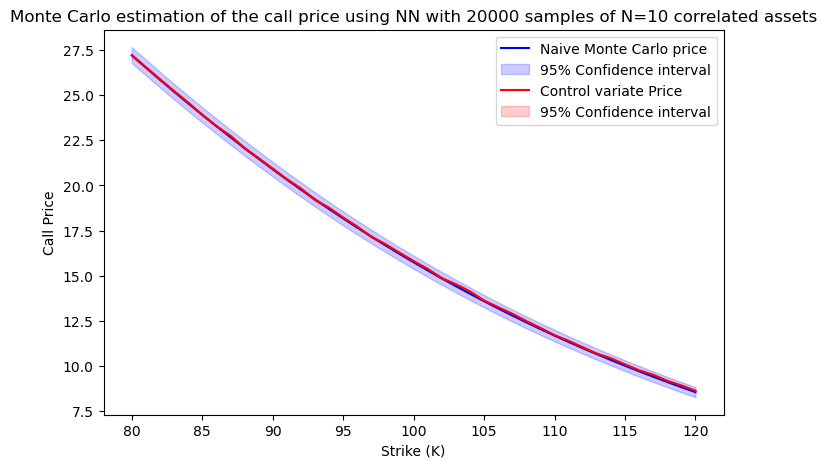

In [16]:
#true_prices = np.array([Call(K) for K in range_K])

plt.figure(figsize=(8, 5))
plt.plot(range_K, prices_MC, 'b', label='Naive Monte Carlo price')
plt.fill_between(range_K, IC_MC[0], IC_MC[1], alpha=0.2, label='95% Confidence interval', color='b')
plt.plot(range_K, prices_ctrl, 'r', label=f'Control variate Price')
plt.fill_between(range_K, IC_ctrl[0], IC_ctrl[1], alpha=0.2, label='95% Confidence interval', color='r')
plt.xlabel('Strike (K)')
plt.ylabel('Call Price')
plt.title(f'Monte Carlo estimation of the call price using NN with {nb_sample} samples of N={N} correlated assets')
plt.legend(loc='best')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


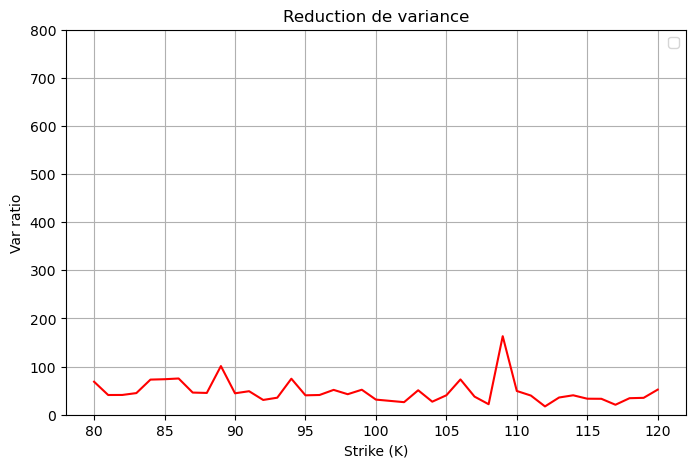

In [15]:
plt.figure(figsize=(8,5))
plt.title('Reduction de variance')
plt.plot(range_K, (std_MC/std_ctrl)**2, 'r')
plt.xlabel('Strike (K)')
plt.ylabel('Var ratio')
plt.ylim([0,800])
plt.legend(loc='best')
plt.grid(True)
plt.show()